In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10, imdb, boston_housing, reuters, cifar100
from tensorflow.keras.utils import to_categorical
import uncertainty_wizard as uwiz
from uncertainty_wizard.models import StochasticMode
from uncertainty_wizard.models.stochastic_utils.layers import UwizBernoulliDropout, UwizGaussianDropout
import platform
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from uncertainty_wizard.models import StochasticMode
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [9]:
# Lenght of training samples
print('Lenght of training samples: ', len(x_train))

# Lenght of test samples
print('\nLenght of test samples: ', len(x_test))

# Shape 
print('\nShape: ', x_train[0].shape)

print("\nShape of x_train:", x_train.shape)


Lenght of training samples:  50000

Lenght of test samples:  10000

Shape:  (32, 32, 3)

Shape of x_train: (50000, 32, 32, 3)


In [4]:
def create_stochastic_model():
    model = uwiz.models.StochasticSequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        UwizBernoulliDropout(0.25, stochastic_mode=StochasticMode()),
    
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
        
    if platform.system() == 'Darwin' and platform.processor() == 'arm':
        opt = tf.keras.optimizers.legacy.Adam()
    else:
        opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model



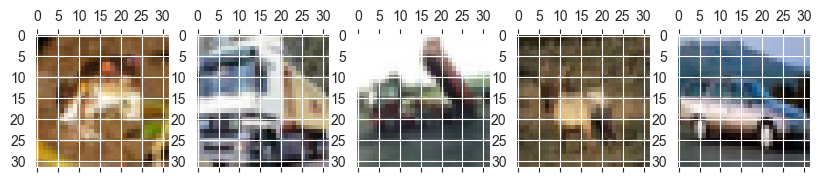

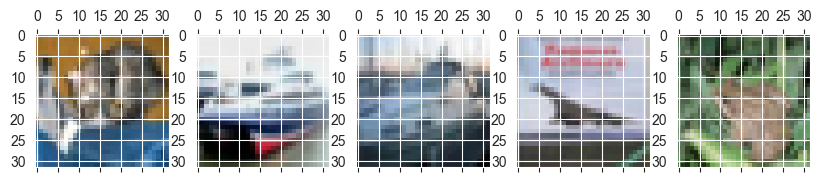

In [5]:
num_images = 5

fig = plt.figure(figsize=(10, 2.5))
for i in range(num_images):
    ax = fig.add_subplot(1, num_images, i+1)
    ax.matshow(x_train[i].squeeze(), cmap='gray')
    
plt.show()

fig2 = plt.figure(figsize=(10, 2.5))
for i in range(num_images):
    ax = fig2.add_subplot(1, num_images, i+1)
    ax.matshow(x_test[i].squeeze(), cmap='gray')
    
plt.show()

In [10]:
model = create_stochastic_model()

history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    batch_size=1000,
                    epochs=5,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3),
                               tf.keras.callbacks.TensorBoard(log_dir='data/logs', histogram_freq=1)])


Epoch 1/5
45/45 [==============================] - 5s 73ms/step - loss: 1.9776 - accuracy: 0.2732 - val_loss: 1.6593 - val_accuracy: 0.3924
Epoch 2/5
45/45 [==============================] - 3s 69ms/step - loss: 1.6130 - accuracy: 0.4061 - val_loss: 1.4072 - val_accuracy: 0.4880
Epoch 3/5
45/45 [==============================] - 3s 68ms/step - loss: 1.4588 - accuracy: 0.4705 - val_loss: 1.2866 - val_accuracy: 0.5412
Epoch 4/5
45/45 [==============================] - 3s 68ms/step - loss: 1.3845 - accuracy: 0.5064 - val_loss: 1.2018 - val_accuracy: 0.5718
Epoch 5/5
45/45 [==============================] - 3s 68ms/step - loss: 1.3513 - accuracy: 0.5286 - val_loss: 1.1909 - val_accuracy: 0.5818


In [11]:
def visualize_feature_maps(sequential_model, image):
    keras_model = sequential_model.inner
    layer_outputs = [layer.output for layer in keras_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
    activation_model = tf.keras.models.Model(inputs=keras_model.input, outputs=layer_outputs)
    # Get feature map activations
    activations = activation_model.predict(image[np.newaxis, ...])
    # Plot the feature maps of the first convolutional layer
    first_layer_activations = activations[0]
    n_features = first_layer_activations.shape[-1]
    size = first_layer_activations.shape[1]
    n_cols = n_features // 16 + min(n_features % 16, 1)
    display_grid = np.zeros((size * n_cols, size * 16))
    for col in range(n_cols):
        for row in range(16):
            if col * 16 + row >= n_features:
                break
            channel_image = first_layer_activations[0, :, :, col * 16 + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title('Feature maps')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()


1/1 [==============================] - 1s 501ms/step


/var/folders/_t/gbby6wvd6hxbkq3zjflmbs7c0000gn/T/ipykernel_21471/729074486.py:19: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
/var/folders/_t/gbby6wvd6hxbkq3zjflmbs7c0000gn/T/ipykernel_21471/729074486.py:22: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


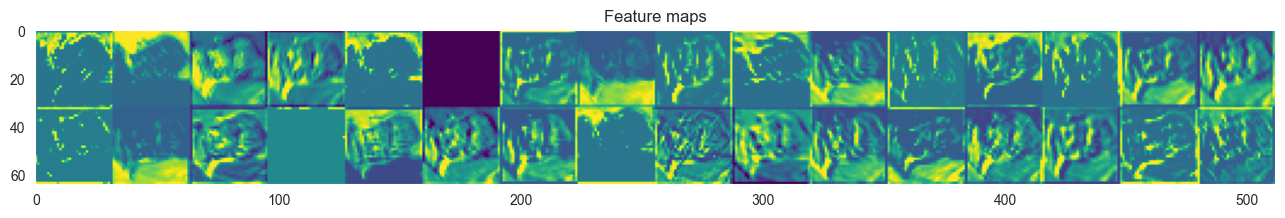

In [12]:
image_to_visualize = x_test[0] 
visualize_feature_maps(model, image_to_visualize)

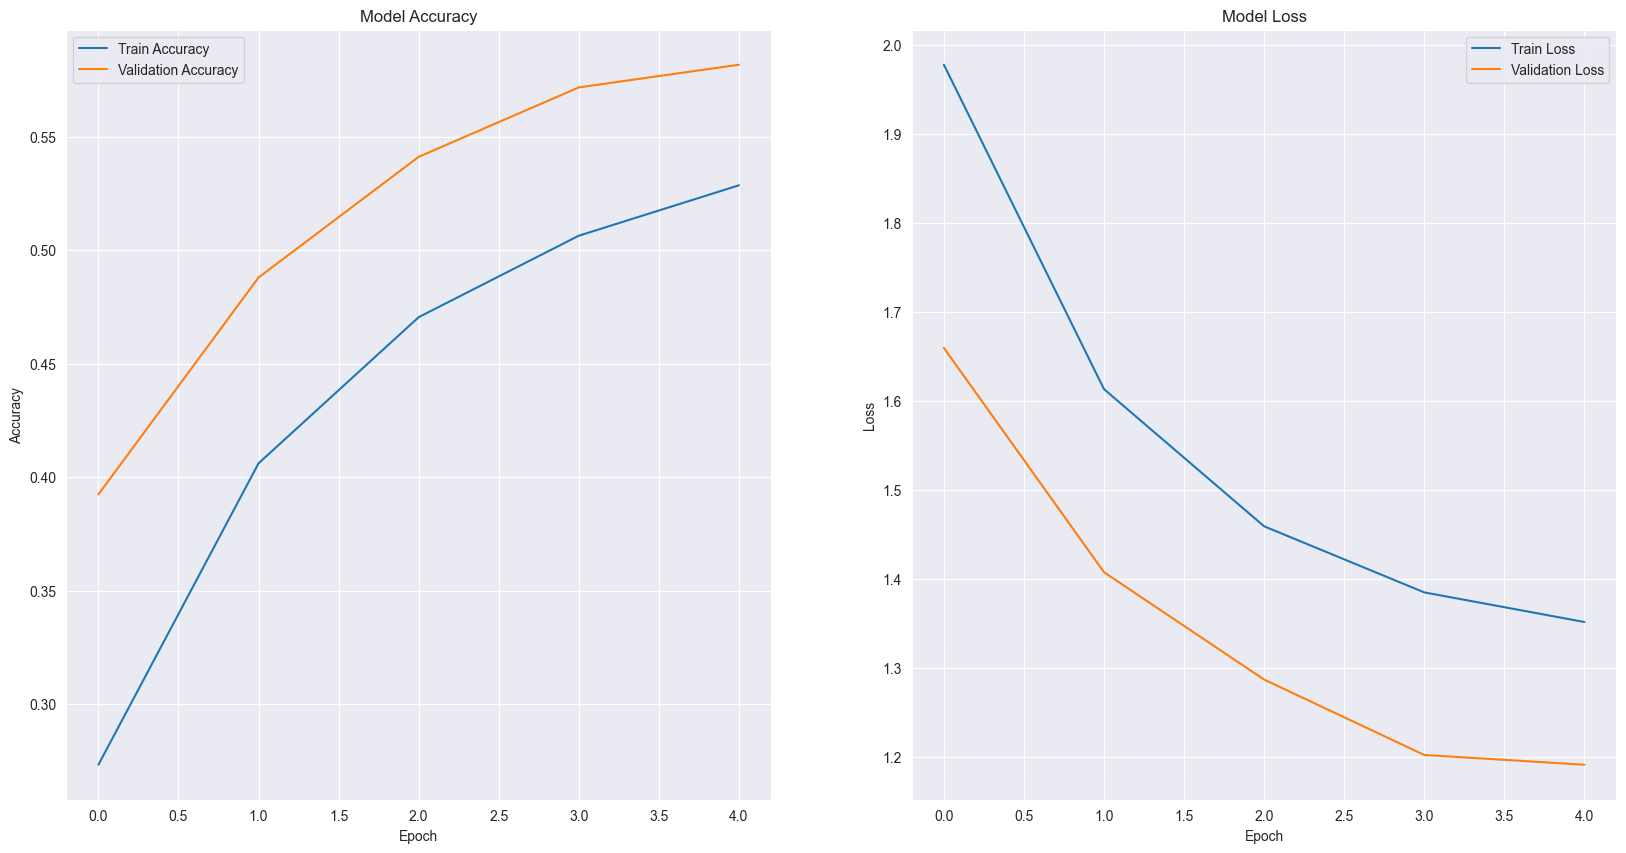

In [13]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
#print('\nTest accuracy', test_acc)
#print('\nTest loss', test_loss)
print(f'\nTest Loss: {test_loss*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%')

# Making predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the mean squared error
mse = tf.reduce_mean(tf.square(y_pred - y_test))
print(f'\nMSE: {mse:.3f}')


num_samples = 25
predictions = model.predict(x_test[:num_samples])
predicted_labels = np.argmax(predictions, axis=1)

313/313 - 4s - loss: 1.2071 - accuracy: 0.5779 - 4s/epoch - 13ms/step

Test Loss: 120.71%, Test Accuracy: 57.79%
313/313 [==============================] - 1s 3ms/step

MSE: 0.055
1/1 [==============================] - 0s 228ms/step


In [18]:
# Confusion Matrix and Classification Report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print("\n")
print(classification_report(y_true, y_pred_classes))

313/313 [==============================] - 1s 3ms/step
[[695  40  33   3   5   6  21   5 121  71]
 [ 39 734   5   1   5   1  12   0  40 163]
 [132  27 404  39  83  75 100  42  41  57]
 [ 56  30  87 285  52 197 128  44  48  73]
 [ 65  19 136  53 369  45 174  98  23  18]
 [ 25  14 121 117  40 497  42  61  33  50]
 [ 14  18  44  36  30  23 756  10  17  52]
 [ 48   9  35  37  58  72  30 599  14  98]
 [110  71  13   5   0   5  11   2 736  47]
 [ 54 133   8   3   4   5  22  18  49 704]]


              precision    recall  f1-score   support

           0       0.56      0.69      0.62      1000
           1       0.67      0.73      0.70      1000
           2       0.46      0.40      0.43      1000
           3       0.49      0.28      0.36      1000
           4       0.57      0.37      0.45      1000
           5       0.54      0.50      0.52      1000
           6       0.58      0.76      0.66      1000
           7       0.68      0.60      0.64      1000
           8       0.66  

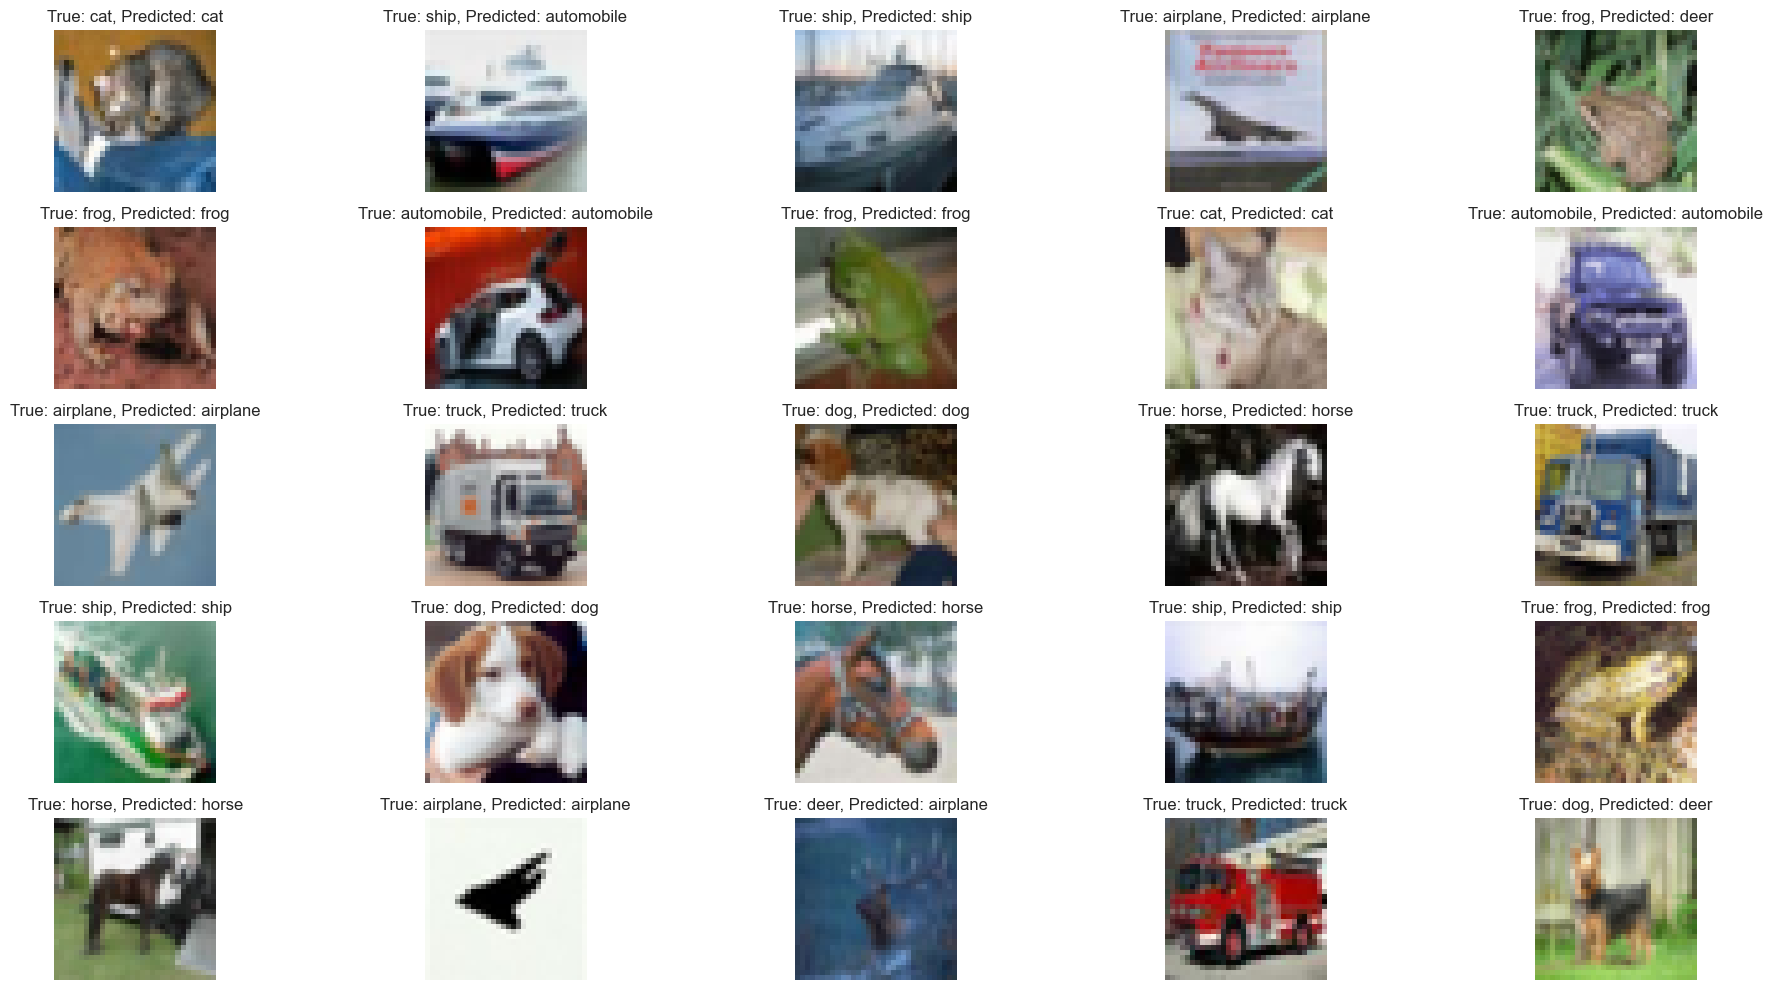

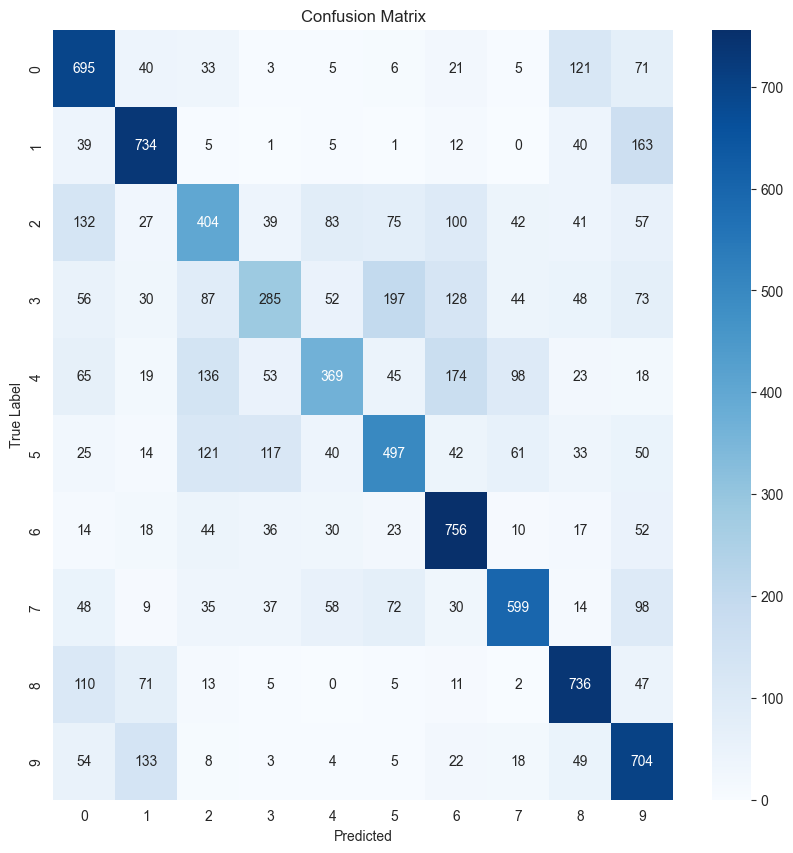

In [29]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(20, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i])  
    true_label_name = class_names[y_true[i]]
    predicted_label_name = class_names[predicted_labels[i]]
    plt.title(f'True: {true_label_name}, Predicted: {predicted_label_name}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()